In [1]:
# changing core directory
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

initialize(config_path='../config/my_configs', version_base=None)

cfg = compose(config_name='attack_run_config.yaml')
# print(OmegaConf.to_yaml(cfg))

/cephfs/projects/danikin/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'attack_run_config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


# Imports

In [3]:
import os

import pandas as pd

from sklearn.manifold import TSNE

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


# Initializing

In [4]:
print("Dataset", cfg["dataset"])
X_train, y_train, X_test, y_test = load_data(cfg["dataset"])
X_train, X_test, y_train, y_test = transform_data(
    X_train, X_test, y_train, y_test, slice_data=cfg["slice"]
)

test_loader = DataLoader(
    MyDataset(X_test, y_test), batch_size=cfg["batch_size"], shuffle=False
)

device = torch.device(cfg["cuda"] if torch.cuda.is_available() else "cpu")

attack_model_path = os.path.join(
    cfg["model_folder"],
    cfg["attack_model"]["name"],
    f"model_{cfg['model_id_attack']}_{cfg['dataset']}.pt",
)

attack_model = get_model(
    cfg["attack_model"]["name"],
    cfg["attack_model"]["params"],
    path=attack_model_path,
    device=device,
    train_mode=cfg["attack_model"]["attack_train_mode"],
)

criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

if cfg["use_disc_check"]:
    disc_check_list = get_disc_list(
        model_name=cfg["disc_model_check"]["name"],
        model_params=cfg["disc_model_check"]["params"],
        list_disc_params=cfg["list_check_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=False,
    )
else:
    disc_check_list = None

estimator = AttackEstimator(
    disc_check_list,
    cfg["metric_effect"],
    cfg["metric_hid"],
    batch_size=cfg["estimator_batch_size"],
)

Dataset PowerCons


In [5]:
alphas = [0]
if "alpha" in cfg["attack"]["attack_params"]:
    alphas = cfg["attack"]["attack_params"]["alpha"]

attacks = list()

for alpha in alphas:
    attack_metrics = pd.DataFrame()
    for eps in cfg["attack"]["attack_params"]["eps"]:
        attack_params = dict(cfg["attack"]["attack_params"])
        attack_params["model"] = attack_model
        attack_params["criterion"] = criterion
        attack_params["estimator"] = estimator
        attack_params["alpha"] = alpha
        attack_params["eps"] = eps

        if "list_reg_model_params" in cfg["attack"]:
            attack_params["disc_models"] = get_disc_list(
                model_name=cfg["disc_model_reg"]["name"],
                model_params=cfg["disc_model_reg"]["params"],
                list_disc_params=cfg["attack"]["list_reg_model_params"],
                device=device,
                path=cfg["disc_path"],
                train_mode=cfg["disc_model_reg"]["attack_train_mode"],
            )

        attacks.append(get_attack(cfg["attack"]["name"], attack_params))

logging
logging


#### Attack and Discriminator choice

In [6]:
disc_model = disc_check_list[0]
attack = attacks[0]

#### Generate Adversarial data

In [7]:
X_orig = test_loader.dataset.X
X_adv = attack.apply_attack(test_loader).squeeze()

metrics = attack.get_metrics().reset_index(drop=True)

X_both = torch.cat([X_orig, X_adv], dim=0)

X_both_if_adv = torch.cat(
    [torch.zeros(X_orig.shape[0]), 
     torch.ones(X_adv.shape[0])]
    )

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
y = test_loader.dataset.y
y_both = torch.cat([y, y], dim=0)

marker_type = y_both + 2*X_both_if_adv.view([-1, 1])

#### Dimensionality Reduction

In [9]:
tsne = TSNE(n_components=2)

X_2d = tsne.fit_transform(X_both)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f59513b6160>
Traceback (most recent call last):
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


# Density estimation

In [10]:
def get_KNN(dist_matrix, n_neigbors=5, neigh_self=True):
    n_neigbors = n_neigbors+1 if neigh_self else n_neigbors # n_neigbors+1, если берётся само значение (расстояние 0) и n соседей

    closest_dist, closest_ind = dist_matrix.topk(n_neigbors, largest=False) 
    
    if not neigh_self:
        closest_dist = closest_dist[:, 1:]
        closest_ind = closest_ind[:, 1:]

    return closest_dist, closest_ind


def distance_weights(neigh_dist, temp=1):
    weights = torch.nn.functional.softmax(-neigh_dist/temp, dim=1) # тепература берётся, чтобы само значение (расстояние 0) не давало слишком большой вес
    
    return weights


def density_val(values, neigh_ind, weights):
    
    density_vector = (values[neigh_ind].squeeze() * weights).sum(1)
    return density_vector

def calculate_density(X, vals, neigh_self=False, temp=1):
    distances = torch.cdist(X, X)

    neigh_dist, neigh_ind = get_KNN(distances, neigh_self=neigh_self)
    neigh_wgts = distance_weights(neigh_dist, temp=temp)
    density = density_val(vals, neigh_ind, neigh_wgts).cpu().detach().numpy()

    return density


In [11]:
disc_preds = disc_model(X_both.unsqueeze(-1).to(device)).cpu()
class_preds = attack_model(X_both.unsqueeze(-1).to(device)).cpu()

In [12]:
disc_density = calculate_density(X_both, disc_preds)
class_density = calculate_density(X_both, class_preds)

# Density Plotting

In [13]:
to_plot = pd.DataFrame()

to_plot[['x', 'y']] = X_2d
to_plot['Class pred'] = class_density
to_plot['Disc pred'] = disc_density
to_plot['Marker'] = marker_type

to_plot['Marker'] = to_plot['Marker'].replace({
    0:'Class 0 orig', 
    1:'Class 1 orig',
    2:'Class 0 adv',
    3:'Class 1 adv'
}) 

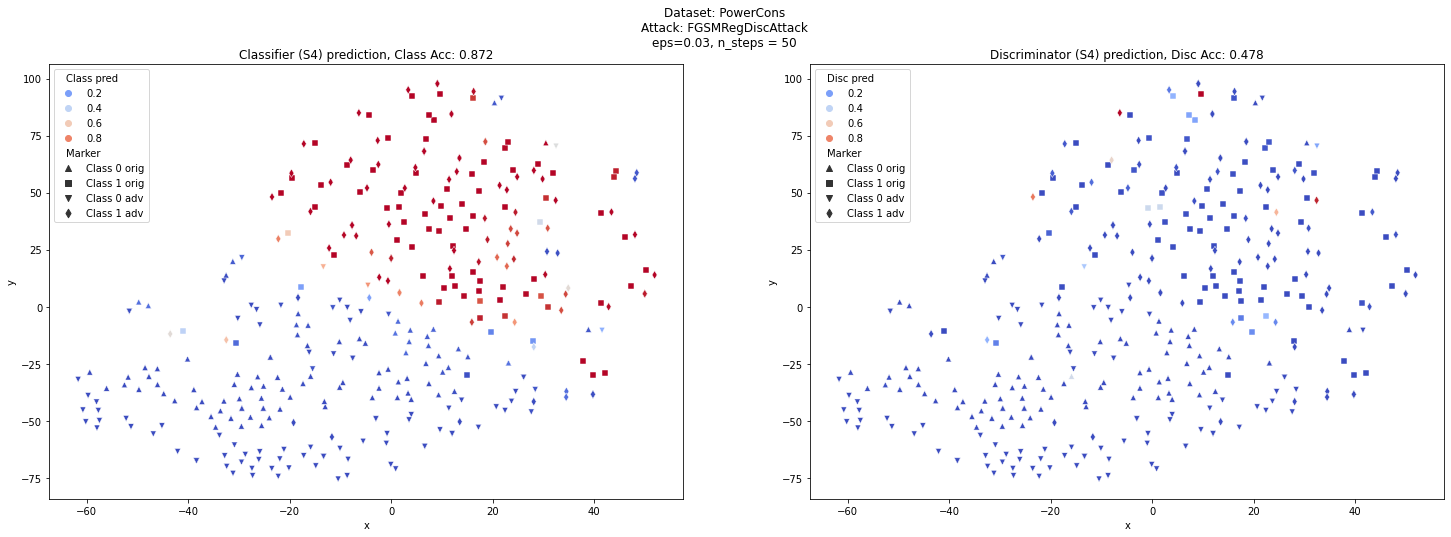

In [19]:
fig, ax = plt.subplots(1, 2, figsize=[25, 8])

sns.scatterplot(
    data=to_plot,
    x="x",
    y="y",
    hue="Class pred",
    palette="coolwarm",
    ax=ax[0],
    style='Marker',
    markers=['^', 's', 'v', 'd']
).set(title=f'Classifier ({type(attack_model).__name__}) prediction, Class Acc: {metrics.iloc[-1, :]["ACC"].round(3)}')

sns.scatterplot(
    data=to_plot,
    x="x",
    y="y",
    hue="Disc pred",
    palette="coolwarm",
    ax=ax[1],
    style='Marker',
    markers=['^', 's', 'v', 'd'],
).set(title=f'Discriminator ({type(disc_model).__name__}) prediction, Disc Acc: {metrics.iloc[-1, :]["ACC_DISC"].round(3)}')

dataset_title = f'Dataset: {cfg["dataset"]}'
attack_name = f'\nAttack: {type(attack).__name__}'
params_title = f'\neps={attack.eps}, n_steps = {attack.n_steps}'

plt.suptitle(dataset_title + attack_name + params_title)

plt.savefig('density.jpeg', dpi=400)